In [1]:
# Using lifelines package to do survival analysis.
import pandas as pd
import numpy as np
import lifelines
import lifelines.statistics

from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import os
import sys
sys.path.append(os.path.abspath( '/mnt/c/Users/ochapman/Documents/Mesirov/Software/oscutils'))
import get
pd.set_option('display.max_columns', None)
#os.chdir('/home/ochapman/Documents/Mesirov/medullo_ecDNA/TCGA-lifelines-survival')
print(os.getcwd())

try:
    os.mkdir('out')
except OSError as error:
    print(error)

/mnt/c/Users/ochapman/Documents/Mesirov/medullo_ecDNA/src/survival
[Errno 17] File exists: 'out'


In [2]:
def median_time_to_event(T,E):
    medIx = np.argsort(T)[len(T)//2]
    med=T[medIx]
    obs=E[medIx]
    if obs:
        print("Median time to event:",med)
    else:
        print("Median time to event is at least:",med,"(event not observed at median)")
    return(med,obs)

def get_pfs(censor_years=None):
    pfs = get.medullo_patients()
    pfs.ecDNA = pfs.ecDNA.map({
        'yes':True,
    }).fillna(False).astype(bool)
    pfs = pfs.dropna(subset=['Survival_time_years','ecDNA','Vital_status'])
    pfs.Vital_status = pfs.Vital_status.map({
        'alive':False,
        'deceased':True
    })
    # event observed if patient has documented relapse or dies.
    pfs.Relapse_status = pfs.apply(axis=1,
                                   func=lambda x:  (not (np.isnan(x["Relapse_interval_years"]))) or x['Vital_status'])
    pfs['Relapse_interval_years'] = pfs.apply(axis=1,
                                              func=lambda x: x['Survival_time_years'] if np.isnan(x['Relapse_interval_years']) else x['Relapse_interval_years'])
    if type(censor_years) == int:
        rows = (pfs['Relapse_interval_years'] > censor_years)
        print("Right-censoring {} intervals to {} years...".format(rows.sum(),censor_years))
        pfs.loc[rows,'Relapse_status'] = False
        pfs.loc[rows,'Relapse_interval_years'] = censor_years
    return pfs

def get_os(censor_years=None):
    os_tbl = get.medullo_patients()
    os_tbl.ecDNA = os_tbl.ecDNA.map({
        'yes':True,
    }).fillna(False).astype(bool)
    os_tbl = os_tbl.dropna(subset=['Survival_time_years','ecDNA'])
    os_tbl.Vital_status = os_tbl.Vital_status.map({
        'alive':False,
        'deceased':True
    }).fillna(False).astype(bool)
    os_tbl = os_tbl.dropna(subset=['Survival_time_years','ecDNA','Vital_status'])
    if type(censor_years) == int:
        rows = (os_tbl['Survival_time_years'] > censor_years)
        print("Right-censoring {} intervals to {} years...".format(rows.sum(),censor_years))
        os_tbl.loc[rows,'Vital_status'] = False
        os_tbl.loc[rows,'Survival_time_years'] = censor_years
    return os_tbl

# Kaplan-Meier curves

In [7]:
def logrank(T,E,ix):
    results = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99)

    results.print_summary()
    print(results.p_value)
    print(results.test_statistic)

def km_pfs(pfs,outfile=None):
    '''
    Assumes pfs is a dataframe with the following columns:
        ecDNA (boolean)
        Relapse_interval_years (float)
        Relapse_status (float)
    '''
    kmf = lifelines.KaplanMeierFitter()

    ix = pfs['ecDNA']
    T = pfs['Relapse_interval_years']
    E = pfs['Relapse_status']

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    ax.set_ylim([0.0, 1.02])

    kmf.fit(T[~ix], E[~ix], label='ecDNA- (n='+str(len(E[~ix]))+')')
    ax = kmf.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6})

    kmf.fit(T[ix], E[ix], label='ecDNA+ (n='+str(len(E[ix]))+')')
    ax = kmf.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6},c="red")

    sns.despine()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    ax.set_xlabel("Time to event (Years)")
    ax.set_ylabel("Progression-free survival (PFS)")
    
    # Save figure
    if outfile != None:
        plt.savefig(outfile)
    
    # Print statistics
    print("n = ",len(T))
    cts = E.groupby(E).count()
    print(cts)
    logrank(T,E,ix)

def km_os(os_tbl,outfile=None):
    '''
    Assumes kmf_os is a dataframe with the following columns:
        ecDNA (boolean)
        Survival_time_years (float)
        Vital_status (float)
    '''
    kmf_os = lifelines.KaplanMeierFitter()

    ix = os_tbl['ecDNA']
    T = os_tbl['Survival_time_years']
    E = os_tbl['Vital_status']

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    ax.set_ylim([0.0, 1.02])

    kmf_os.fit(T[~ix], E[~ix], label='ecDNA- (n='+str(len(E[~ix]))+')')
    ax = kmf_os.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6})

    kmf_os.fit(T[ix], E[ix], label='ecDNA+ (n='+str(len(E[ix]))+')')
    ax = kmf_os.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6},c="red")

    sns.despine()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    ax.set_xlabel("Time to event (Years)")
    ax.set_ylabel("Overall Survival (OS)")
    
    # Save figure
    if outfile != None:
        plt.savefig(outfile)

    # Print statistics
    print("n = ",len(T))
    cts = E.groupby(E).count()
    print(cts)
    logrank(T,E,ix)

Right-censoring 74 intervals to 5 years...
n =  340
Relapse_status
False    251
True      89
Name: Relapse_status, dtype: int64


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          14.76 <0.005     13.00

0.00012211028279726456
14.759814097960387


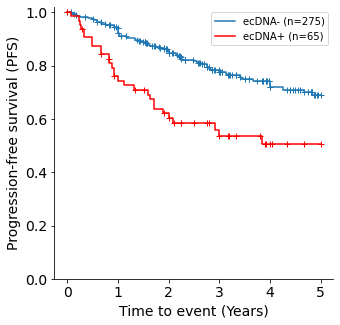

In [10]:
# PFS
pfs = get_pfs(censor_years=5)
pfs = pfs[pfs.Subgroup != 'WNT'] # drop WNTs
km_pfs(pfs,outfile='out/figure1c_pfs.svg')

In [ ]:
# OS
os_tbl = get_os(censor_years=5)
os_tbl = os_tbl[os_tbl.Subgroup != 'WNT'] # drop WNTs
km_os(os_tbl,outfile='out/figure1d_os.svg')

In [ ]:
pfs

# Kaplan-Meier by subgroup

## SHH

In [ ]:
ost=get_os(5)
ost=ost[ost.Subgroup == 'SHH']
km_os(ost,'out/km_os_shh.svg')

In [ ]:
pfs = get_pfs(5)
pfs = pfs[pfs.Subgroup == 'SHH']
km_pfs(pfs, 'out/km_pfs_shh.svg')

## G3

In [ ]:
ost=get_os(5)
ost=ost[ost.Subgroup == 'G3']
km_os(ost,'out/km_os_g3.svg')

In [ ]:
pfs = get_pfs(5)
pfs = pfs[pfs.Subgroup == 'G3']
km_pfs(pfs, 'out/km_pfs_g3.svg')

## G4

In [ ]:
ost=get_os(5)
ost=ost[ost.Subgroup == 'G4']
km_os(ost,'out/km_os_g4.svg')

In [ ]:
pfs = get_pfs(5)
pfs = pfs[pfs.Subgroup == 'G4']
km_pfs(pfs, 'out/km_pfs_g4.svg')

# Survival by amplification type

In [13]:
# AmpliconClassifier annotations using custom code.

def _classify_patient(series):
    '''
    Helper function. See label_patients_by_AC_class.
    Inputs:
        series: pd.Series
    Returns: string
    '''
    if series.ecDNA:
        return 'ecDNA'
    elif series.BFB:
        return 'BFB'
    elif series['complex non-cyclic']:
        return 'complex non-cyclic'
    elif series.linear:
        return 'linear'
    else:
        return 'no fSCNA'

def label_patients_by_AC_class(pts):
    ac = get.medullo_AmpliconClassifier()
    pts['BFB'] = False
    pts['complex non-cyclic'] = False
    pts['linear'] = False
    for i in range(len(ac)):
        row = ac.iloc[i]
        pt = row.Patient_ID
        if pt in pts.index:
            if row['BFB+'] == 'Positive':
                pts.loc[pt,'BFB'] = True
            if row['amplicon_decomposition_class'] == 'Linear amplification':
                pts.loc[pt,'linear'] = True
            if row['amplicon_decomposition_class'] == 'Complex non-cyclic':
                pts.loc[pt,'complex non-cyclic'] = True
        pts['AmpliconClass'] = pts.apply(func=_classify_patient,axis=1)
    return pts

def km_pfs_amp_type(pfs,outfile=None):
    '''
    Assumes pfs is a dataframe with the following columns:
        AmpliconClass (string)
        Relapse_interval_years (float)
        Relapse_status (float)
    '''
    kmf = lifelines.KaplanMeierFitter()

    ix = pfs['AmpliconClass']
    T = pfs['Relapse_interval_years']
    E = pfs['Relapse_status']

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    ax.set_ylim([0.0, 1.02])
    
    for cat in ix.unique():
        i = ix==cat
        kmf.fit(T[i], E[i], label=f'{cat} (n={str(len(E[i]))})')
        ax = kmf.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6})

    sns.despine()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    ax.set_xlabel("Time to event (Years)")
    ax.set_ylabel("Progression-free survival (PFS)")
    
    # Save figure
    if outfile != None:
        plt.savefig(outfile)
    
    # Print statistics
    print("n = ",len(T))
    cts = E.groupby(E).count()
    print(cts)

def km_os_amp_type(os_tbl,outfile=None):
    '''
    Assumes os_tbl is a dataframe with the following columns:
        AmpliconClass (string)
        Survival_time_years (float)
        Vital_status (float)
    '''
    kmf = lifelines.KaplanMeierFitter()

    ix = os_tbl['AmpliconClass']
    T = os_tbl['Survival_time_years']
    E = os_tbl['Vital_status']

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    ax.set_ylim([0.0, 1.02])
    
    for cat in ix.unique():
        i = ix==cat
        kmf.fit(T[i], E[i], label=f'{cat} (n={str(len(E[i]))})')
        ax = kmf.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6})

    sns.despine()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    ax.set_xlabel("Time to event (Years)")
    ax.set_ylabel("Overall survival (OS)")
    
    # Save figure
    if outfile != None:
        plt.savefig(outfile)
    
    # Print statistics
    print("n = ",len(T))
    cts = E.groupby(E).count()
    print(cts)
    
def logrank(T,E,ix1,ix2):
    results = logrank_test(T[ix1], T[ix2], E[ix1], E[ix2], alpha=.99)

    results.print_summary()
    print(results.p_value)
    print(results.test_statistic)
    
def logrank_pfs(pfs):
    '''
    Assumes pfs is a dataframe with the following columns:
        AmpliconClass (string)
        Relapse_interval_years (float)
        Relapse_status (float)
    '''
    ix = pfs['AmpliconClass']
    T = pfs['Relapse_interval_years']
    E = pfs['Relapse_status']
    cats = ix.unique()
    for i in range(len(cats)):
        for j in range(i+1,len(cats)):
            c1 = cats[i]
            c2 = cats[j]
            print(f'Log-rank test: {c1} vs {c2}')
            logrank(T,E,ix==c1,ix==c2)
    return

def logrank_os(ost):
    '''
    Assumes pfs is a dataframe with the following columns:
        AmpliconClass (string)
        Survival_time_years (float)
        Vital_status (float)
    '''
    ix = ost['AmpliconClass']
    T = ost['Survival_time_years']
    E = ost['Vital_status']
    cats = ix.unique()
    for i in range(len(cats)):
        for j in range(i+1,len(cats)):
            c1 = cats[i]
            c2 = cats[j]
            print(f'Log-rank test: {c1} vs {c2}')
            logrank(T,E,ix==c1,ix==c2)

Right-censoring 74 intervals to 5 years...
n =  338
Relapse_status
False    251
True      87
Name: Relapse_status, dtype: int64


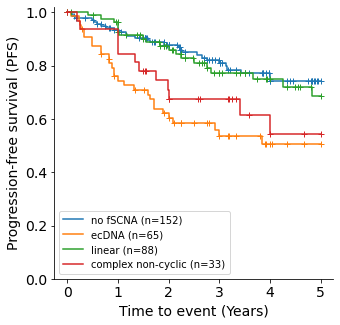

In [14]:
pfs = get_pfs(censor_years=5)
pfs = label_patients_by_AC_class(pfs)
pfs = pfs[pfs.AmpliconClass != 'BFB'] # at n = 2, this is uninformative.
pfs = pfs[pfs.Subgroup != 'WNT']
km_pfs_amp_type(pfs,outfile='out/km_pfs_by_amp_type.svg')

In [15]:
logrank_pfs(pfs)
# Significant tests:
# no fSCNA vs ecDNA
# no fSCNA vs complex non-cyclic
# ecDNA vs linear

Log-rank test: no fSCNA vs ecDNA


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          15.31 <0.005     13.42

9.123691265436295e-05
15.309904018469833
Log-rank test: no fSCNA vs linear


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.24 0.62      0.68

0.6233187295854905
0.2412305867880166
Log-rank test: no fSCNA vs complex non-cyclic


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.48 0.03      4.86

0.03439385748327859
4.475017138948882
Log-rank test: ecDNA vs linear


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.56 <0.005      8.97

0.0019881652968688854
9.560430016794857
Log-rank test: ecDNA vs complex non-cyclic


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.76 0.38      1.38

0.3846552457062892
0.7557709382827734
Log-rank test: linear vs complex non-cyclic


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.78 0.10      3.39

0.09553216552165796
2.778591238542282


Right-censoring 78 intervals to 5 years...
n =  338
Vital_status
False    271
True      67
Name: Vital_status, dtype: int64


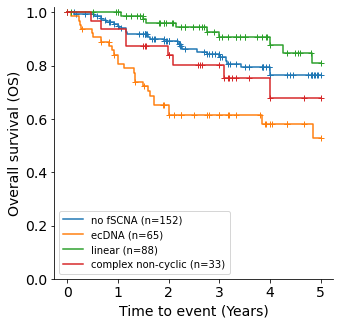

In [16]:
ost = get_os(censor_years=5)
ost = label_patients_by_AC_class(ost)
ost = ost[ost.AmpliconClass != 'BFB'] # at n = 2, this is uninformative.
ost = ost[ost.Subgroup != 'WNT']
km_os_amp_type(ost, outfile='out/km_os_by_amp_type.svg')

In [17]:
logrank_os(ost)
# Significant tests:
# no fSCNA vs ecDNA
# ecDNA vs linear

Log-rank test: no fSCNA vs ecDNA


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.91 <0.005     11.58

0.00032727655629601066
12.907451746628485
Log-rank test: no fSCNA vs linear


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.01 0.16      2.68

0.15630163896801721
2.009647423795437
Log-rank test: no fSCNA vs complex non-cyclic


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.72 0.40      1.34

0.3959242055474258
0.7206700591295154
Log-rank test: ecDNA vs linear


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.82 <0.005     16.09

1.4335140330652815e-05
18.824006476976166
Log-rank test: ecDNA vs complex non-cyclic


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.45 0.12      3.09

0.11724719831734694
2.4537134696185237
Log-rank test: linear vs complex non-cyclic


/home/ochapman/miniconda3/envs/py3/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.76 0.05      4.25

0.0524928008331372
3.759992919297852


In [7]:
pfs

,Source,ecDNA,Subgroup,Sex,Age_at_diagnosis,Vital_status,Relapse_status,Relapse_interval_years,Survival_time_years,Citations,Subtype_northcott,Aliases,BFB,complex non-cyclic,linear,AmpliconClass
Patient_ID,,,,,,,,,,,,,,,,
MB018,Archer,False,G3,f,13.00,False,False,5.000000,7.000000,"1,2",II,DO35553,False,False,False,no fSCNA
MB036,Archer,True,G3,m,4.00,False,False,5.000000,6.000000,"1,2",II,DO35573,False,False,False,ecDNA
MB037,Archer,False,SHH,f,1.00,False,False,5.000000,7.000000,"1,2",SHH (infant),DO35574,False,False,False,no fSCNA
MB088,Archer,False,SHH,m,2.00,False,True,0.668036,6.000000,"1,2",SHH (infant),DO35620,False,False,True,linear
MB091,Archer,False,G4,m,15.00,False,False,5.000000,6.000000,"1,2",VIII,DO35623,False,True,True,complex non-cyclic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SJ008037,St Jude,False,G4,m,6.56,False,False,2.166667,2.166667,4,NaN,NaN,False,False,False,no fSCNA
SJ008038,St Jude,True,G4,m,8.70,False,False,1.916667,1.916667,4,NaN,NaN,False,False,True,ecDNA
SJ008039,St Jude,False,G3,m,8.19,False,False,2.000000,2.000000,4,NaN,NaN,False,False,False,no fSCNA


# Dissertation chapter 1 title slide

In [6]:
def ch1_title_slide(pfs,outfile='out/ch1_title_slide.svg'):
    '''
    Assumes pfs is a dataframe with the following columns:
        ecDNA (boolean)
        Relapse_interval_years (float)
        Relapse_status (float)
    '''
    kmf = lifelines.KaplanMeierFitter()

    ix = pfs['ecDNA']
    T = pfs['Relapse_interval_years']
    E = pfs['Relapse_status']

    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    ax.set_ylim([0.0, 1.02])

    kmf.fit(T[~ix], E[~ix], label='ecDNA- (n='+str(len(E[~ix]))+')')
    ax = kmf.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6})

    kmf.fit(T[ix], E[ix], label='ecDNA+ (n='+str(len(E[ix]))+')')
    ax = kmf.plot(ax=ax,show_censors=True,ci_show=False,censor_styles={'ms':6},c="red")

    sns.despine()#(left=True,bottom=True)
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    # set visibility of x-axis as False
    ax.get_xaxis().set_visible(False)
    # set visibility of y-axis as False
    ax.get_yaxis().set_visible(False)
    # remove legend
    ax.get_legend().remove()
    
    # Save figure
    #if outfile != None:
        #plt.savefig(outfile)
    # Print statistics
    print("n = ",len(T))
    cts = E.groupby(E).count()
    print(cts)
    logrank(T,E,ix)

Right-censoring 74 intervals to 5 years...
n =  340
Relapse_status
False    251
True      89
Name: Relapse_status, dtype: int64


NameError: name 'logrank' is not defined

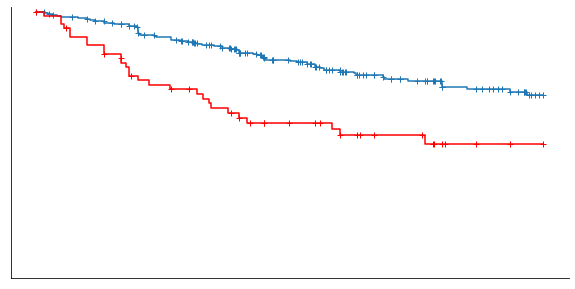

In [7]:
pfs = get_pfs(censor_years=5)
pfs = pfs[pfs.Subgroup != 'WNT'] # drop WNTs
ch1_title_slide(pfs)